<a href="https://colab.research.google.com/github/lidorsandak/ad_ML_Competition_m5/blob/main/lightgbm_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M5 Forecasting Challenge: LightGBM pipeline

---
--

#### **Set Env**



In [1]:
# Cell 1: Setup and Data Loading
from google.colab import drive
drive.mount('/content/drive')

# Define path to your data on Google Drive
PROJECT_PATH = '/content/drive/MyDrive/M5_Project/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# First, you might need to install Optuna
!pip install optuna -q

import optuna

# General imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random


from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

##### **Data**

Use preprocessed data from drive

1. Load data
2. Modify to fit model

In [3]:

# Load data
input_folder = PROJECT_PATH + 'processed_data/'
# Load the dataframes from the Parquet files
df_featured = pd.read_parquet(input_folder + 'df_featured.parquet', engine='pyarrow')
original_df = pd.read_parquet(input_folder + 'original_df.parquet', engine='pyarrow')


print("Processed Data loaded successfully!")


Processed Data loaded successfully!


**Submission data preprocessing**

In [4]:
sample_submission = pd.read_csv(PROJECT_PATH + 'forecast_submission.csv')
submission_ids = sample_submission['id'].str.split('_', expand=True)
submission_ids.columns = ['store_id_str', 'date_str']
submission_dates = pd.to_datetime(submission_ids['date_str'], format='%Y%m%d')
# The forecast horizon H is the number of unique dates in the submission file
H = submission_dates.nunique()
print(f"The Forecast Horizon (H) is: {H} days.")

The Forecast Horizon (H) is: 92 days.


**Split to train/validation**

In [5]:
# --- train and validation sets from the FEATURED data ---
last_train_date_featured = df_featured['date'].max() - pd.to_timedelta(H, unit='D')
validation_start_date_featured = last_train_date_featured + pd.to_timedelta(1, unit='D')

train_final = df_featured[df_featured['date'] <= last_train_date_featured]
val_final = df_featured[df_featured['date'] >= validation_start_date_featured]

# --- Define our features (X) and target (y) ---
TARGET = 'revenue'

FEATURES = [col for col in train_final.columns if col not in [TARGET, 'store_name', 'date', 'weekday', 'event']]

X_train = train_final[FEATURES]
y_train = train_final[TARGET]

X_val = val_final[FEATURES]
y_val = val_final[TARGET]

print("Training data shape (X, y):", X_train.shape, y_train.shape)
print("Validation data shape (X, y):", X_val.shape, y_val.shape)

display(X_train.head())
display(X_train.columns)

Training data shape (X, y): (17446, 82) (17446,)
Validation data shape (X, y): (1012, 82) (1012,)


,store_id,year,month,day_of_month,day_of_week,week_of_year,quarter,day_of_year,is_weekend,is_monday,...,store_dow_5_interaction,store_dow_6_interaction,weekend_month_interaction,event_weekend_interaction,trend_store_interaction,revenue_expanding_mean,revenue_expanding_std,revenue_vs_store_avg,revenue_vs_roll_mean_28,revenue_zscore_28
28,0,2011,2,26,5,8,1,57,1,0,...,0,0,2,0,0,12.036119,0.190489,-0.088538,-0.088538,-0.464793
29,0,2011,2,27,6,8,1,58,1,0,...,0,0,2,0,0,12.042764,0.190448,0.186047,0.192609,1.010673
30,0,2011,2,28,0,9,1,59,0,1,...,0,0,0,0,0,12.047978,0.189302,0.151216,0.162776,0.853288
31,0,2011,3,1,1,9,1,60,0,0,...,0,0,0,0,0,12.043144,0.188057,-0.145040,-0.138982,-0.730613
32,0,2011,3,2,2,9,1,61,0,0,...,0,0,0,0,0,12.040541,0.185584,-0.080679,-0.078255,-0.412501


Index(['store_id', 'year', 'month', 'day_of_month', 'day_of_week',
       'week_of_year', 'quarter', 'day_of_year', 'is_weekend', 'is_monday',
       'is_friday', 'days_since_start', 'days_since_start_sq',
       'days_since_start_cb', 'years_since_2011', 'month_sin', 'month_cos',
       'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'is_event', 'is_christmas',
       'is_new_year', 'is_thanksgiving', 'is_major_holiday',
       'days_to_christmas', 'is_pre_christmas', 'is_post_christmas',
       'is_month_end', 'is_month_start', 'revenue_lag_1', 'revenue_lag_7',
       'revenue_lag_14', 'revenue_lag_28', 'revenue_weekend_lag_7',
       'revenue_weekday_lag_7', 'revenue_roll_mean_7', 'revenue_roll_std_7',
       'revenue_roll_min_7', 'revenue_roll_max_7', 'revenue_roll_median_7',
       'revenue_roll_mean_14', 'revenue_roll_std_14', 'revenue_roll_min_14',
       'revenue_roll_max_14', 'revenue_roll_median_14', 'revenue_roll_mean_28',
       'revenue_roll_std_28', 'revenue_roll_min_28', 're

# Modeling

**Strategic Choice:**

❌ Option A: Forecast all 11 independently

- Pros: Simple, allows customization per store
- Cons: Forecasts won't reconcile (sum of stores ≠ total)

✅ Option B: Bottom-Up Reconciliation (RECOMMENDED)

- Forecast stores 1-10 individually
- Sum them to get store 0
- Pros: Guaranteed consistency, leverages store-specific patterns
- Cons: Errors accumulate


✅ Option C: Top-Down Reconciliation

- Forecast store 0 (total)
- Allocate proportionally to stores 1-10
- Pros: Total is most stable (less variance)
- Cons: Loses store-specific dynamics

🎯 Hybrid Approach

- Forecast stores 1-10 with separate models
- Forecast store 0 independently
- Use hierarchical reconciliation (MinTrace algorithm) to enforce consistency
- This gives best of both worlds!



#### LightGBM

| Model | Pros for Your Data | Cons for Your Data | Overall Score |
|-------|-------------------|-------------------|---------------|
| **ARIMA/SARIMA** | ✓ Handles 7-day seasonality<br>✓ Statistical rigor | ✗ Struggles with holidays<br>✗ Can't use 88 features<br>✗ Separate model per store needed | 4/10 |
| **Prophet** | ✓ Excellent holiday handling<br>✓ Automatic weekly seasonality<br>✓ Handles trend changes | ✗ Can't use lag features<br>✗ Limited to temporal regressors<br>✗ No store interactions | 6/10 |
| **XGBoost** | ✓ Uses all 88 features<br>✓ Handles non-linearity<br>✓ Robust to outliers<br>✓ Feature importance | ✗ Needs recursive forecasting logic<br>✗ No native uncertainty | **8/10** ⭐ |
| **LightGBM** | ✓ Same as XGBoost<br>✓ Faster training<br>✓ Better with categorical features | ✗ Same cons as XGBoost | **8/10** ⭐ |
| **LSTM/RNN** | ✓ Learns temporal patterns<br>✓ Handles sequences | ✗ Needs much more data<br>✗ Hard to interpret<br>✗ Overkill for this problem | 5/10 |
| **Linear Regression** | ✓ Simple, interpretable | ✗ Can't capture non-linear trend<br>✗ Poor with holidays | 3/10 |
| **Ensemble (Hybrid)** | ✓ Combines strengths<br>✓ More robust | ✗ More complex<br>✗ Harder to maintain | **9/10** 🏆 |

┌─────────────────────────────────────────────────────────┐
│                    STAGE 1: BASE FORECASTS              │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  For Each Store (1-10):                                │
│  ┌────────────────────────────────────────────┐        │
│  │  Model A: XGBoost (70% weight)             │        │
│  │  - Uses all 88 features                    │        │
│  │  - Recursive 92-day forecasting            │        │
│  │  - Separate model per store                │        │
│  └────────────────────────────────────────────┘        │
│                        +                                │
│  ┌────────────────────────────────────────────┐        │
│  │  Model B: Prophet (30% weight)             │        │
│  │  - Handles trend + seasonality             │        │
│  │  - Holiday calendar (Christmas, etc.)      │        │
│  │  - Fallback for extreme dates              │        │
│  └────────────────────────────────────────────┘        │
│                        ↓                                │
│           Weighted Average = Base Forecast              │
│                                                         │
├─────────────────────────────────────────────────────────┤
│                   STAGE 2: RECONCILIATION               │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  1. Sum base forecasts: store_0_base = Σ(stores 1-10)  │
│  2. Forecast store_0 independently with XGBoost        │
│  3. Apply MinTrace reconciliation:                     │
│     - Adjust all forecasts to maintain hierarchy       │
│     - Minimize variance in adjustments                 │
│  4. Final forecasts respect: store_0 = Σ(stores 1-10)  │
│                                                         │
└─────────────────────────────────────────────────────────┘

In [7]:

# --- 1. Identify Categorical Features ---
# It's important to tell LightGBM which features are categorical.
# This allows it to handle them more efficiently than treating them as numbers.
categorical_features = [
    'store_id',
    'year',
    'month',
    'day_of_month',
    'day_of_week',
    'week_of_year',
    'quarter',
    'store_revenue_rank',
    'is_weekend',
    'is_monday',
    'is_friday',
    'is_event',
    'is_christmas',
    'is_new_year',
    'is_thanksgiving',
    'is_major_holiday',
    'is_pre_christmas',
    'is_post_christmas',
    'is_month_end',
    'is_month_start',
    'weekend_month_interaction', # Add other interactions if they are label-based
    'event_weekend_interaction',
]

# --- 2. Initialize and Train the Model ---
# We'll start with a solid set of default parameters.
lgbm = lgb.LGBMRegressor(
    objective='rmse',  # Our evaluation metric
    metric='rmse',
    n_estimators=1000, # We'll train up to 1000 trees, but...
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,         # Use all available CPU cores
    force_col_wise=True
)

print("Training LightGBM model...")
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10, verbose=True)], # ...early stopping will find the best number for us!
    categorical_feature=categorical_features
)

# --- 3. Make Predictions on the Validation Set ---
val_predictions_log = lgbm.predict(X_val)

# --- 4. Inverse Transform the Predictions ---
# This is a critical step! Our model predicted log(revenue+1).
# We need to convert it back to actual revenue.
val_predictions = np.expm1(val_predictions_log)

# Also inverse transform the true values for comparison
y_val_original = np.expm1(y_val)

# --- 5. Evaluate the Model ---
lgbm_rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions))

print(f"\nSeasonal Naive Baseline RMSE: 4324.50")
print(f"LightGBM Model RMSE: {lgbm_rmse:.2f}")

improvement = (4324.50 - lgbm_rmse) / 4324.50 * 100
print(f"\nImprovement over baseline: {improvement:.2f}%")


Training LightGBM model...
[LightGBM] [Info] Total Bins 12268
[LightGBM] [Info] Number of data points in the train set: 17446, number of used features: 81
[LightGBM] [Info] Start training from score 10.184870
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's rmse: 0.0270261

Seasonal Naive Baseline RMSE: 4324.50
LightGBM Model RMSE: 4686.17

Improvement over baseline: -8.36%


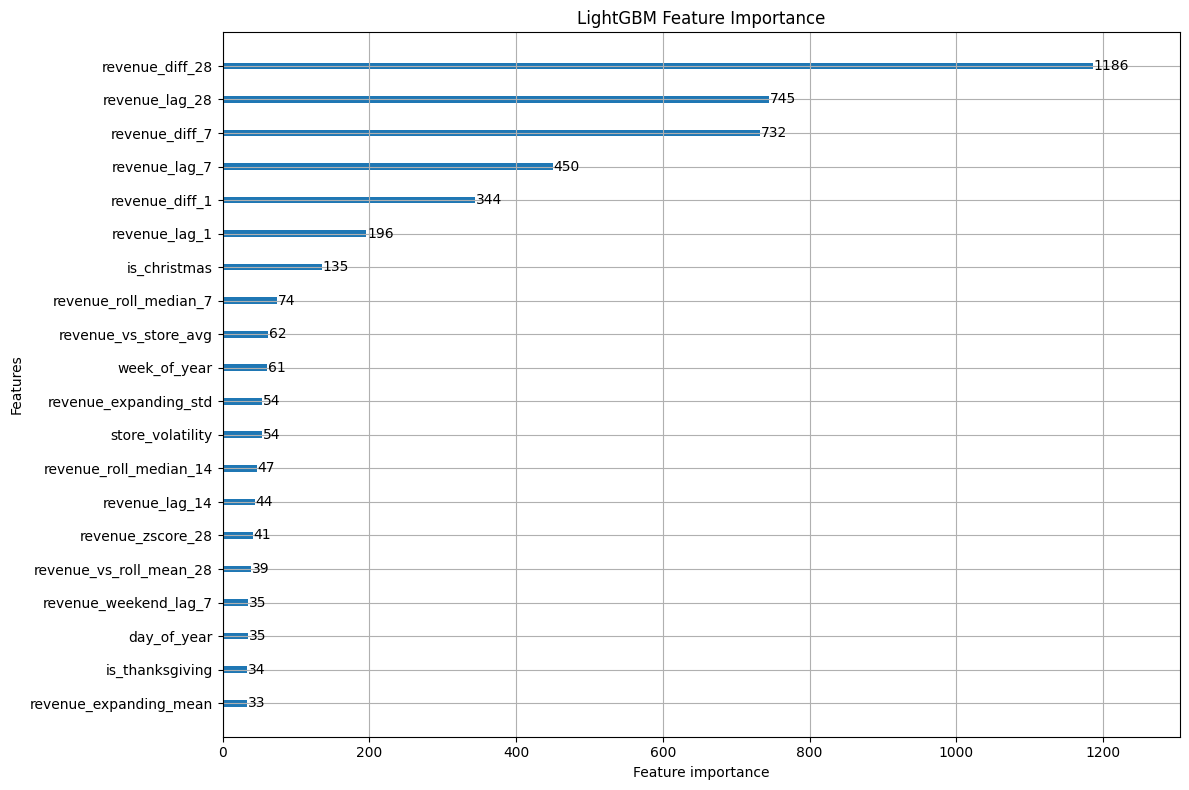

In [8]:
# Plot feature importance
lgb.plot_importance(lgbm, figsize=(12, 8), max_num_features=20)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

### 5. Hyperparameter Tuning

Hyperparameter Tuning with Optuna

In [ ]:


# --- 1. Define the Objective Function for Optuna ---
def objective(trial):
    # --- Define the search space for hyperparameters ---
    # Optuna will pick values from these ranges.
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'n_estimators': 1000, # We still use early stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1,
    }

    # --- Train the model with the suggested params ---
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(10, verbose=False)], # Verbose=False keeps the output clean
        categorical_feature=categorical_features # Re-use our list of categoricals
    )

    # --- Make predictions and calculate RMSE ---
    preds_log = model.predict(X_val)
    preds = np.expm1(preds_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val), preds))

    return rmse

# --- 2. Create and Run the Optuna Study ---
# We want to 'minimize' the RMSE.
study = optuna.create_study(direction='minimize')
# We'll run 50 trials. For a real competition, you might do 100-200.
study.optimize(objective, n_trials=50)


# --- 3. Print the Best Results ---
print("\nOptuna Study Finished!")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value (RMSE): ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
# --- 4. Train the Final Tuned Model ---
# Get the best hyperparameters from the study
best_params = best_trial.params
best_params['objective'] = 'rmse'
best_params['metric'] = 'rmse'
best_params['random_state'] = 42
best_params['n_estimators'] = 1000 # Use a high number, early stopping will handle it
best_params['n_jobs'] = -1


print("\nTraining final model with best parameters...")
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10, verbose=True)],
    categorical_feature=categorical_features
)

# --- Evaluate the Final Tuned Model ---
final_preds_log = final_model.predict(X_val)
final_preds = np.expm1(final_preds_log)
final_rmse = np.sqrt(mean_squared_error(y_val_original, final_preds))


print(f"Final Tuned LightGBM RMSE: {final_rmse:.2f}")


# The Final Prediction Pipeline

In [ ]:
# --- 1. Retrain the final model on ALL available data ---
# This gives the model maximum information before forecasting.

# First, get the full set of features and the target
ALL_FEATURES = [col for col in df_featured.columns if col not in [TARGET, 'store_name', 'date', 'weekday']]
X_all = df_featured[ALL_FEATURES]
y_all = df_featured[TARGET]

# Use the best parameters found by Optuna
final_model_for_submission = lgb.LGBMRegressor(**best_trial.params)

print("Retraining model on all available data...")
final_model_for_submission.fit(X_all, y_all, categorical_feature=categorical_features)
print("Model retraining complete.")


In [ ]:
df['store_id'].unique()

In [ ]:

# --- 2. Set up the Recursive Forecasting Loop ---
# This is where the magic happens.

# Get the last known date from our original data
last_known_date = df['date'].max()
# Get the last `N` days of data to compute future lags/rolling features.
# A safe number is the max lag or window size we used. Let's use 120 days.
history_df = df_featured.groupby('store_id').tail(120).copy()

future_predictions = []

print(f"\nStarting recursive forecast for {H} days...")
for i in range(H):
    # The date we want to predict
    predict_date = last_known_date + pd.to_timedelta(i + 1, unit='D')

    # Create a placeholder row for each store for the future date
    future_rows = []
    for store_id in df['store_id'].unique():
        future_rows.append({'date': predict_date, 'store_id': store_id})
    future_df = pd.DataFrame(future_rows)

    # Merge calendar events for the future date
    future_df = pd.merge(future_df, calendar_df, on='date', how='left')
    future_df['event'].fillna('NoEvent', inplace=True)

    # Create features for this future row using our past history
    # We combine history with the new rows to calculate lags correctly
    combined_df = pd.concat([history_df, future_df], ignore_index=True)
    featured_future = create_features(combined_df)

    # Isolate the last 10 rows which are the ones we want to predict
    predict_data = featured_future[featured_future['date'] == predict_date].copy()

    # Select the features for prediction
    X_predict = predict_data[ALL_FEATURES]

    # Predict in log scale
    preds_log = final_model_for_submission.predict(X_predict)
    # Inverse transform to original scale
    preds_revenue = np.expm1(preds_log)

    # Store the predictions
    predict_data['revenue'] = preds_revenue
    future_predictions.append(predict_data[['date', 'store_id', 'revenue']])

    # CRITICAL: Update history for the next loop iteration
    # The predicted data becomes part of the new history
    history_df = pd.concat([history_df, predict_data], ignore_index=True)

print("Recursive forecast complete.")

# Combine all predictions into a single dataframe
final_predictions_df = pd.concat(future_predictions, ignore_index=True)



In [ ]:
# Get the last known date from our original data
last_known_date = df['date'].max()
# Get the last `N` days of data to compute future lags/rolling features.
# A safe number is the max lag or window size we used. Let's use 120 days.
history_df = df_featured.groupby('store_id').tail(120).copy()

future_predictions = []

# The date we want to predict
predict_date = last_known_date + pd.to_timedelta(i + 1, unit='D')

# Create a placeholder row for each store for the future date
future_rows = []
for store_id in df['store_id'].unique():
    future_rows.append({'date': predict_date, 'store_id': store_id})
future_df = pd.DataFrame(future_rows)

# Merge calendar events for the future date
future_df = pd.merge(future_df, calendar_df, on='date', how='left')
future_df['event'].fillna('NoEvent', inplace=True)

# Create features for this future row using our past history
# We combine history with the new rows to calculate lags correctly
combined_df = pd.concat([history_df, future_df], ignore_index=True)
featured_future = create_features(combined_df)
featured_future
# Isolate the last 10 rows which are the ones we want to predict
predict_data = featured_future.tail(10)
predict_data
# # Select the features for prediction
# X_predict = predict_data[ALL_FEATURES]

# # Predict in log scale
# preds_log = final_model_for_submission.predict(X_predict)
# # Inverse transform to original scale
# preds_revenue = np.expm1(preds_log)

# # Store the predictions
# predict_data['revenue'] = preds_revenue
# future_predictions.append(predict_data[['date', 'store_id', 'revenue']])

# # CRITICAL: Update history for the next loop iteration
# # The predicted data becomes part of the new history
# history_df = pd.concat([history_df, predict_data], ignore_index=True)


In [ ]:
final_predictions_df


In [ ]:
# --- 3. Format for Submission ---

# We start with our dataframe of predictions for stores 1-10
individual_store_preds = final_predictions_df.copy()
print(f"Generated predictions for {individual_store_preds['store_id'].nunique()} individual stores.")

# Group by date and sum the predictions of stores 1-10 to create the forecast for store 0
aggregate_preds = individual_store_preds.groupby('date')['revenue'].sum().reset_index()
aggregate_preds['store_id'] = 0 # Assign the correct store ID for the aggregate
print("\nCreated aggregate predictions for 'store_id = 0' by summing individual stores.")

# We now have two dataframes: one for stores 1-10, one for store 0. Let's combine them.
# Reorder columns in aggregate_preds to match individual_store_preds for concatenation
aggregate_preds = aggregate_preds[['date', 'store_id', 'revenue']]
# Append the aggregate predictions to the individual ones
all_predictions_df = pd.concat([individual_store_preds.rename(columns={'revenue':'prediction'}), aggregate_preds.rename(columns={'revenue':'prediction'})], ignore_index=True)
all_predictions_df
# Now we create the 'id' column from this complete set of predictions
all_predictions_df['id'] = all_predictions_df['store_id'].astype(str) + '_' + all_predictions_df['date'].dt.strftime('%Y%m%d')

# Merge with the sample submission to ensure correct format and order
submission_df_final = sample_submission[['id']].merge(all_predictions_df[['id', 'prediction']], on='id', how='left')

submission_df_final
# # # --- Final Sanity Check ---
# if submission_df_final['prediction'].isnull().any():
#     print("\nWARNING: There are still NaN values in the submission file! Debugging needed.")
#     # Add a check to see which IDs failed to merge
#     print("IDs that failed to find a match:")
#     print(submission_df_final[submission_df_final['prediction'].isnull()])
# else:
#     print("\nSUCCESS! All 1,012 IDs matched and predictions are filled.")

# Save the submission file
submission_df_final.to_csv( DATA_PATH+ 'submission_df.csv', index=False)

print("\nSubmission file 'submission_df.csv' created successfully!")
print("Here's a sample of the submission file:")
print(submission_df_final.head())

In [ ]:
aggregate_preds

#  Model Explainability with SHAP

In [ ]:
# Install SHAP
!pip install shap -q

import shap

# --- Explain the final model trained on all data ---
# We use a TreeExplainer for tree-based models like LightGBM
explainer = shap.TreeExplainer(final_model_for_submission)
# Calculate SHAP values for the validation set (as a sample)
shap_values = explainer.shap_values(X_val)

# --- Create a SHAP Summary Plot ---
# This is like a super-powered feature importance plot.
# It shows not only the importance but also the direction of the effect.
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=20) # Classic bar chart
shap.summary_plot(shap_values, X_val, max_display=20) # Beeswarm plot (even better!)

### 3. Final Results records

Date: 29.12
*   **Best Validation RMSE:** '3614.85`
*   **Best Leaderboard RMSE:** `7225.3`
*   **Key Insight:** The model's feature importance plot revealed that high-level calendar features (`month`, `day_of_month`) and `store_id` were the most powerful predictors, indicating strong seasonal and store-level base patterns. Lag and rolling mean features were crucial for capturing recent dynamics.